In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease                   
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2972 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.2 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1303 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2069 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [28.6 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [55.2 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1937 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1008 kB]
G

Setting up libvorbisfile3:amd64 (1.3.6-2ubuntu1) ...
Setting up libsndfile1:amd64 (1.0.28-7ubuntu0.1) ...
Setting up libxml2:amd64 (2.9.10+dfsg-5ubuntu0.20.04.5) ...
Setting up libvorbis-dev:amd64 (1.3.6-2ubuntu1) ...
Setting up libsndfile1-dev (1.0.28-7ubuntu0.1) ...
Setting up shared-mime-info (1.15-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     |████████████████████████████████| 34.5 MB 15.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.8 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 8.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 252 kB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 636 kB/s eta 0:00:011
     |████████████████████████████

In [2]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
step_size = 40960 # clip をずらすときの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
        
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_s" + str(step_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, step_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

loading ../data/arrays/c81920_s40960_f32_clips.npy ...
The clip array has 28461 clips.


In [3]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

loading ../data/arrays/c81920_s40960_f32_clips_w10240_h640_cqts.npy ...
The cqt array has 28461 cqts.
cqts.shape: (28461, 84, 129)
Type(cqts[0][0][0]): <class 'numpy.complex64'>
np.max(cqts[0][0]): (0.021538047+0.007131239j)


In [4]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if num == 0:
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

loading ../data/arrays/c81920_s40960_f32_clips_w10240_h640_cqt_chromas.npy ...
The cqt_chroma array has 28461 cqt_chromas.
cqt_chromas.shape: (28461, 129, 12)
Type(cqt_chromas[0][0][0]): <class 'numpy.float32'>
np.max(cqt_chromas[0][0]): 0.0078125


In [5]:
# max_norm 作成

num_divide = 8

max_norm_filename = clips_filename + "_d" + str(num_divide) + "_max_norms"

if os.path.isfile(max_norm_filename + ".npy"):
    print("loading " + max_norm_filename + ".npy ...")
    max_norms= np.load(max_norm_filename + ".npy")
else:
    print("creating " + max_norm_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("max_norm progress: clip " + str(num + 1) + " / " + str(len(clips)))
        max_norm = [np.max(clip[int((i / num_divide) * len(clip)):int(((i + 1) / num_divide) * len(clip))] ** 2) for i in range(num_divide)]
    
        if num == 0:
            max_norms = np.array(max_norm)
        else:
            max_norms = np.vstack((max_norms, np.array(max_norm)))
        num += 1
        
    np.save(max_norm_filename, max_norms)
    
print("The max_norm array has " + str(max_norms.shape[0]) + " max_norms.")
print("max_norms.shape: " + str(max_norms.shape))
print("Type(max_norms[0][0]): " + str(type(max_norms[0][0])))
print("np.max(max_norms[0]): " + str(np.max(max_norms[0])))

loading ../data/arrays/c81920_s40960_f32_clips_d8_max_norms.npy ...
The max_norm array has 28461 max_norms.
max_norms.shape: (28461, 8)
Type(max_norms[0][0]): <class 'numpy.float32'>
np.max(max_norms[0]): 0.0179649


In [6]:
# 学習データとテストデータに分ける

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)
    
cqt_chroma_sum_threshold = 0.1 # 次の window の sum が閾値に満たないときに除外します
test_data_rate = 0.2
weight = 0.01 # max_norm の重み

window_num_per_clip = cqt_chromas.shape[1]

cqt_chromas = np.array([np.hstack((cqt_chromas[i], np.repeat(np.array([max_norms[i]]), cqt_chromas.shape[1], axis=0) * weight)) for i in range(len(max_norms))])
cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

clips = np.delete(clips, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)
cqt_chromas = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x_test = np.apply_along_axis(normalize, 2, cqt_chromas[:int(cqt_chromas.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, cqt_chromas.shape[2], 1))
x_train = np.apply_along_axis(normalize, 2, cqt_chromas[int(cqt_chromas.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(cqt_chromas.shape[0] - int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, cqt_chromas.shape[2], 1))
y_test =  np.apply_along_axis(normalize, 1, cqt_chromas[:int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, :])
y_train = np.apply_along_axis(normalize, 1, cqt_chromas[int(cqt_chromas.shape[0] * test_data_rate):, window_num_per_clip, :])

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

x_train.shape: (22351, 129, 20, 1)
x_test.shape: (5587, 129, 20, 1)
y_train.shape: (22351, 20)
y_test.shape: (5587, 20)


In [7]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input, MaxPooling2D
from keras.optimizers import Adam

learning_rate = 0.0001
 
model = keras.models.Sequential()
model.add(Conv2D(32, (3, 1), activation="leaky_relu", input_shape=(window_num_per_clip, cqt_chromas.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.9))
model.add(Conv2D(64, (3, 1), activation="leaky_relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.9))
model.add(Conv2D(128, (3, 1), activation="leaky_relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.9))
model.add(Conv2D(256, (3, 1), activation="leaky_relu"))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Dropout(0.9))
model.add(Flatten())
model.add(Dense(units=cqt_chromas.shape[2]))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 20, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 20, 64)        6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 20, 64)        0

In [9]:
# 学習
batch_size = 256
epochs = 100
model_name = "cqt_chroma_batch" + str(batch_size) + "_e" + str(epochs)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/" + model_name)

Epoch 1/100
88/88 [==============================] - 44s 493ms/step - loss: 2.9279 - accuracy: 0.1047 - val_loss: 2.9932 - val_accuracy: 0.1505
Epoch 2/100
88/88 [==============================] - 44s 496ms/step - loss: 2.6148 - accuracy: 0.1289 - val_loss: 2.9932 - val_accuracy: 0.1452
Epoch 3/100
88/88 [==============================] - 45s 507ms/step - loss: 2.5461 - accuracy: 0.1435 - val_loss: 2.9917 - val_accuracy: 0.0988
Epoch 4/100
88/88 [==============================] - 44s 502ms/step - loss: 2.5162 - accuracy: 0.1604 - val_loss: 2.9900 - val_accuracy: 0.0988
Epoch 5/100
88/88 [==============================] - 44s 498ms/step - loss: 2.5000 - accuracy: 0.1702 - val_loss: 2.9884 - val_accuracy: 0.0988
Epoch 6/100
88/88 [==============================] - 45s 506ms/step - loss: 2.4900 - accuracy: 0.1827 - val_loss: 2.9829 - val_accuracy: 0.1453
Epoch 7/100
88/88 [==============================] - 44s 495ms/step - loss: 2.4849 - accuracy: 0.1808 - val_loss: 2.9557 - val_accuracy:

88/88 [==============================] - 44s 499ms/step - loss: 2.4341 - accuracy: 0.2654 - val_loss: 2.4876 - val_accuracy: 0.0988
Epoch 58/100
88/88 [==============================] - 44s 503ms/step - loss: 2.4348 - accuracy: 0.2599 - val_loss: 2.4874 - val_accuracy: 0.0988
Epoch 59/100
88/88 [==============================] - 44s 502ms/step - loss: 2.4352 - accuracy: 0.2615 - val_loss: 2.4872 - val_accuracy: 0.0988
Epoch 60/100
88/88 [==============================] - 44s 500ms/step - loss: 2.4337 - accuracy: 0.2656 - val_loss: 2.4870 - val_accuracy: 0.0988
Epoch 61/100
88/88 [==============================] - 44s 499ms/step - loss: 2.4335 - accuracy: 0.2675 - val_loss: 2.4872 - val_accuracy: 0.0988
Epoch 62/100
88/88 [==============================] - 44s 503ms/step - loss: 2.4332 - accuracy: 0.2631 - val_loss: 2.4869 - val_accuracy: 0.0988
Epoch 63/100
88/88 [==============================] - 44s 503ms/step - loss: 2.4336 - accuracy: 0.2627 - val_loss: 2.4870 - val_accuracy: 0.098

INFO:tensorflow:Assets written to: ../data/models/cqt_chroma_batch256_e100/assets


INFO:tensorflow:Assets written to: ../data/models/cqt_chroma_batch256_e100/assets


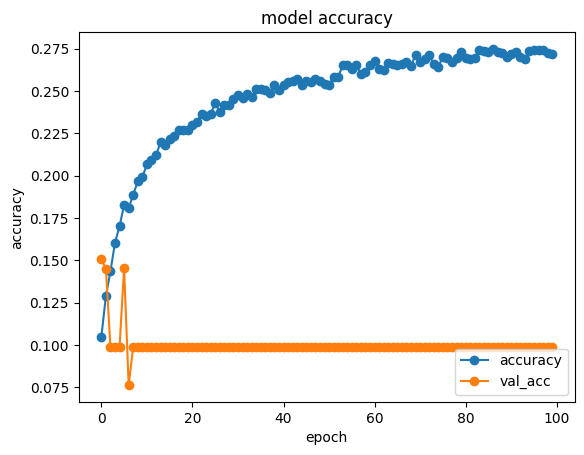

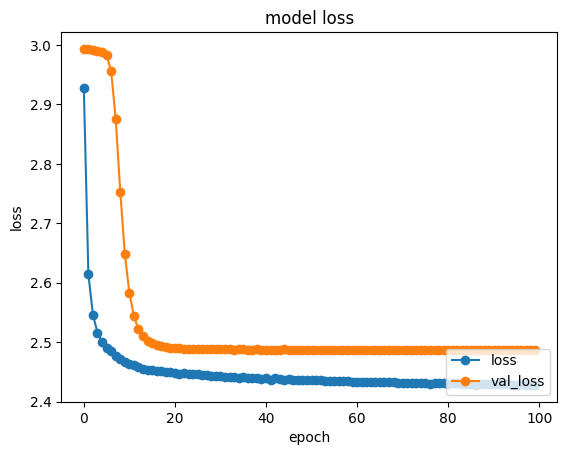

In [10]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [11]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

model = load_model("../data/models/" + model_name)
file_name = "out_" + model_name
num_clips = 10

def add_fade(x, fadetime, sr):
    ft_len = int(fadetime*sr)
    r = np.arange(0, ft_len)*np.pi/ft_len
    w_fo = (0.5+0.5*np.cos(r))**0.5
    w_fi = (0.5-0.5*np.cos(r))**0.5
    
    x[0:ft_len]        *= w_fi
    x[clip_size-ft_len::] *= w_fo
    return x

def gen_xfade(x_pre, x_next, fadetime, sr):
    ft_len = int(fadetime*sr)
    if x_pre is None:
        xfade = x_next
    else:
        x_pre_begin = x_pre[:x_pre.shape[0] - ft_len]
        x_pre_end = x_pre[x_pre.shape[0] - ft_len:]
        x_pre_len = clip_size
        x_next_len = clip_size
        x_pre_len -= ft_len
        x_next_len -= ft_len
        xfade = np.concatenate((x_pre_begin, np.concatenate((x_pre_end, np.zeros(x_next_len))) + x_next))
    return xfade

def create_music(fname):
    first_index = np.random.randint(0, len(x_test))
    predict_index = first_index
    out = None
    
    for i in range(num_clips):
        print("-- generate " + str(i + 1) + " / " + str(num_clips))
        predict = model.predict(np.array([x_test[predict_index]]))

        index = 0
        similar_index = 0
        cos_sim = -1
        for cqt_chroma in x_test[:, 0:1, :, 0]:
            tmp_sim = cosine_similarity(predict, cqt_chroma) 
            if tmp_sim > cos_sim:
                cos_sim = tmp_sim
                similar_index = index
            index += 1

        print("cos_sim: " + str(cos_sim))
        print("predict: " + str(predict))
        print("x_test[similar_index]: " + str(x_test[similar_index, 0, :, 0]))
        print("similar_index: " + str(similar_index))
        print("--")

        predict_index = similar_index

        tmp = add_fade(clips[predict_index], 0.1, SAMPLING_RATE)
        out = gen_xfade(out, tmp, 0.1, SAMPLING_RATE)
    
    
    sf.write(fname, out, SAMPLING_RATE, subtype="PCM_16")

fname = "../data/out/" + file_name + "_1.wav"
print("creating " + fname + " ...")
create_music(fname)

fname = "../data/out/" + file_name + "_2.wav"
print("creating " + fname + " ...")
create_music(fname)

fname = "../data/out/" + file_name + "_3.wav"
print("creating " + fname + " ...")
create_music(fname)

creating ../data/out/out_cqt_chroma_batch256_e100_1.wav ...
-- generate 1 / 10
1/1 [==============================] - 0s 76ms/step
cos_sim: [[0.94541836]]
predict: [[0.08929459 0.08596422 0.08452626 0.07714909 0.07729989 0.07303878
  0.08662657 0.08571199 0.0828473  0.0755494  0.08296128 0.09533792
  0.00051504 0.0004308  0.00036205 0.00043464 0.00052414 0.00049561
  0.00046606 0.00046431]]
x_test[similar_index]: [1.2152407e-01 3.2847829e-02 7.2056159e-02 1.1246201e-01 7.6440260e-02
 5.1305775e-02 1.2689580e-01 1.2594035e-01 6.2957756e-02 5.1584527e-02
 7.1966060e-02 9.4010867e-02 5.2586267e-07 1.4895780e-07 1.6113910e-06
 3.0618881e-07 5.3734084e-07 1.5936415e-06 1.0906239e-06 2.6678015e-06]
similar_index: 1747
--
-- generate 2 / 10
1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9454161]]
predict: [[0.08929328 0.0859713  0.08453219 0.07715546 0.07729923 0.07304042
  0.08662406 0.08570908 0.08284242 0.07554327 0.08295318 0.09534439
  0.00051498 0.00043067 0.00036203 0

1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9454161]]
predict: [[0.08929328 0.0859713  0.08453219 0.07715546 0.07729923 0.07304042
  0.08662406 0.08570908 0.08284242 0.07554327 0.08295318 0.09534439
  0.00051498 0.00043067 0.00036203 0.00043457 0.00052399 0.00049545
  0.00046589 0.0004642 ]]
x_test[similar_index]: [1.2152407e-01 3.2847829e-02 7.2056159e-02 1.1246201e-01 7.6440260e-02
 5.1305775e-02 1.2689580e-01 1.2594035e-01 6.2957756e-02 5.1584527e-02
 7.1966060e-02 9.4010867e-02 5.2586267e-07 1.4895780e-07 1.6113910e-06
 3.0618881e-07 5.3734084e-07 1.5936415e-06 1.0906239e-06 2.6678015e-06]
similar_index: 1747
--
-- generate 5 / 10
1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9454161]]
predict: [[0.08929328 0.0859713  0.08453219 0.07715546 0.07729923 0.07304042
  0.08662406 0.08570908 0.08284242 0.07554327 0.08295318 0.09534439
  0.00051498 0.00043067 0.00036203 0.00043457 0.00052399 0.00049545
  0.00046589 0.0004642 ]]
x_test[similar_index]:

1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9454161]]
predict: [[0.08929328 0.0859713  0.08453219 0.07715546 0.07729923 0.07304042
  0.08662406 0.08570908 0.08284242 0.07554327 0.08295318 0.09534439
  0.00051498 0.00043067 0.00036203 0.00043457 0.00052399 0.00049545
  0.00046589 0.0004642 ]]
x_test[similar_index]: [1.2152407e-01 3.2847829e-02 7.2056159e-02 1.1246201e-01 7.6440260e-02
 5.1305775e-02 1.2689580e-01 1.2594035e-01 6.2957756e-02 5.1584527e-02
 7.1966060e-02 9.4010867e-02 5.2586267e-07 1.4895780e-07 1.6113910e-06
 3.0618881e-07 5.3734084e-07 1.5936415e-06 1.0906239e-06 2.6678015e-06]
similar_index: 1747
--
-- generate 8 / 10
1/1 [==============================] - 0s 15ms/step
cos_sim: [[0.9454161]]
predict: [[0.08929328 0.0859713  0.08453219 0.07715546 0.07729923 0.07304042
  0.08662406 0.08570908 0.08284242 0.07554327 0.08295318 0.09534439
  0.00051498 0.00043067 0.00036203 0.00043457 0.00052399 0.00049545
  0.00046589 0.0004642 ]]
x_test[similar_index]: